In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

pd.set_option('max_rows', 20)



# Financial Sector - Estimation

All data series were downloaded from the [World Bank Website](http://data.worldbank.org)

* Financial Depth: Domestic credit provided by financial sector (% of GDP) - EXPLANATORY VARIABLE
* Real GDP Per Capita: GDP per capita, PPP (current international $) - RESPONSE VARIABLE
* Inflation Rate Inflation, consumer prices (annual %) - CONTROL VARIABLE
* Merchandise Trade: Merchandise trade (% of GDP) - CONTROL VARIABLE
* Primary completion rate, total (% of relevant age group) - We opted for this as a education proxy - CONTROL VARIABLE


## Load

In [2]:
df = pd.read_excel('Data.xlsx',None)

In [3]:
def sortDf(df,key):
    df.drop(['Country Name','Indicator Code','Indicator Name',], axis=1, inplace=True)
    df = pd.DataFrame(df.set_index('Country Code').stack())
    df.columns = [key]
    return df

In [4]:
dfsList = []
for key in df.keys():
    dfsList.append(sortDf(df[key],key))

In [5]:
df = pd.concat(dfsList,axis=1)
df

Pop  PrimaryRateCompletion  MerchanTrade  \
Country Code                                                         
ABW          1960     54208.0                    NaN           NaN   
             1961     55435.0                    NaN           NaN   
             1962     56226.0                    NaN           NaN   
             1963     56697.0                    NaN           NaN   
             1964     57029.0                    NaN           NaN   
             1965     57360.0                    NaN           NaN   
             1966     57712.0                    NaN           NaN   
             1967     58049.0                    NaN           NaN   
             1968     58385.0                    NaN           NaN   
             1969     58724.0                    NaN           NaN   
...                       ...                    ...           ...   
ZWE          2006  13127942.0                    NaN     78.987541   
             2007  13297798.0                    NaN     93.538297   
             2008  13495462.0                    NaN    116.629226   
             2009  13720997.0                    NaN     63.367034   
             2010  13973897.0                    NaN     74.284772   
             2011  14255592.0                    NaN     72.215785   
             2012  14565482.0              89.225418     66.833044   
             2013  14898092.0              90.249062     57.873718   
             2014  15245855.0                    NaN     51.164230   
             2015  15602751.0                    NaN     48.338968   

                   InflationRate  GrossCapital  RealGdpPerCapita  FinancDepth  
Country Code                                                                   
ABW          1960            NaN           NaN               NaN          NaN  
             1961            NaN           NaN               NaN          NaN  
             1962            NaN           NaN               NaN          NaN  
             1963            NaN           NaN               NaN          NaN  
             1964            NaN           NaN               NaN          NaN  
             1965            NaN           NaN               NaN          NaN  
             1966            NaN           NaN               NaN          NaN  
             1967            NaN           NaN               NaN          NaN  
             1968            NaN           NaN               NaN          NaN  
             1969            NaN           NaN               NaN          NaN  
...                          ...           ...               ...          ...  
ZWE          2006    1096.677633      1.571161       1449.120124          NaN  
             2007   24411.030809      7.109753       1415.027698          NaN  
             2008            NaN      5.127906       1170.461903          NaN  
             2009            NaN     15.104423       1229.382424          NaN  
             2010       3.034479     23.979764       1360.876026          NaN  
             2011       3.277509     22.392920       1523.621784          NaN  
             2012       3.922235     13.612891       1679.125594          NaN  
             2013       1.631622     13.033016       1743.210783          NaN  
             2014      -0.217286     13.236799       1798.059812          NaN  
             2015      -2.398710     13.239581       1793.586092          NaN  

[14628 rows x 7 columns]

# Selecting Our Sample

We will try to use a similar time window of 15 years, thus from 2000 to 2015

In [6]:
df = df.swaplevel()

listOfYears = []
for i in range(1999,2015):
    listOfYears.append(str(i))

df.sort_index(inplace=True)
idx = pd.IndexSlice
df = df.loc[idx[listOfYears,:],:]

Now we have to find countries with complete data

In [7]:
df = df.swaplevel().sort_index()
df.index.names=["Country Code","Year"]
df

Pop  PrimaryRateCompletion  MerchanTrade  \
Country Code Year                                                    
ABW          1999     89004.0             101.619118    196.364238   
             2000     90858.0              97.215950    272.496034   
             2001     92894.0              94.335510    249.698162   
             2002     94995.0              94.755241    180.566748   
             2003     97015.0              90.155090    220.119233   
             2004     98742.0              90.559898    315.211778   
             2005    100031.0              88.197968    373.397244   
             2006    100830.0              93.127357    389.796606   
             2007    101218.0              95.588242    393.812800   
             2008    101342.0              95.133034    410.724326   
...                       ...                    ...           ...   
ZWE          2005  12984418.0                    NaN     72.977288   
             2006  13127942.0                    NaN     78.987541   
             2007  13297798.0                    NaN     93.538297   
             2008  13495462.0                    NaN    116.629226   
             2009  13720997.0                    NaN     63.367034   
             2010  13973897.0                    NaN     74.284772   
             2011  14255592.0                    NaN     72.215785   
             2012  14565482.0              89.225418     66.833044   
             2013  14898092.0              90.249062     57.873718   
             2014  15245855.0                    NaN     51.164230   

                   InflationRate  GrossCapital  RealGdpPerCapita  FinancDepth  
Country Code Year                                                              
ABW          1999       2.280372     27.723498               NaN    44.554334  
             2000       4.044021     25.494114               NaN    44.102276  
             2001       2.883604     23.701659               NaN    44.822054  
             2002       3.315775     26.914487               NaN    49.103685  
             2003       3.657377     29.207629               NaN    54.435883  
             2004       2.529938     28.790409               NaN    51.686147  
             2005       3.395625     33.573158               NaN    54.159209  
             2006       3.608711     35.207778               NaN    53.381129  
             2007       5.391203     32.399015               NaN    51.376289  
             2008       8.957732     32.690226               NaN    47.309394  
...                          ...           ...               ...          ...  
ZWE          2005     302.116996      1.525177       1472.435072    55.330227  
             2006    1096.677633      1.571161       1449.120124          NaN  
             2007   24411.030809      7.109753       1415.027698          NaN  
             2008            NaN      5.127906       1170.461903          NaN  
             2009            NaN     15.104423       1229.382424          NaN  
             2010       3.034479     23.979764       1360.876026          NaN  
             2011       3.277509     22.392920       1523.621784          NaN  
             2012       3.922235     13.612891       1679.125594          NaN  
             2013       1.631622     13.033016       1743.210783          NaN  
             2014      -0.217286     13.236799       1798.059812          NaN  

[4207 rows x 7 columns]

In [8]:
# Check not null countries
# pd.set_option('max_rows', 500)
# ~(df.isnull().groupby(level="Country Code").any().any(axis=1))

In [9]:
penn_table = pd.read_stata("pwt90_labor_detail.dta")

In [10]:
penn_table["year"] = penn_table["year"].astype(int)
penn_table["year"] = penn_table["year"].astype(str)
penn_table.set_index(["countrycode","year"],inplace=True)
penn_table.index.names = ["Country Code","Year"]
penn_table = penn_table[["yr_sch"]]

In [11]:
penn_table.head()

yr_sch
Country Code Year        
ABW          1950     NaN
             1951     NaN
             1952     NaN
             1953     NaN
             1954     NaN

In [12]:
df = pd.concat([df, penn_table], axis=1)
df

Pop  PrimaryRateCompletion  MerchanTrade  \
Country Code Year                                                    
ABW          1950         NaN                    NaN           NaN   
             1951         NaN                    NaN           NaN   
             1952         NaN                    NaN           NaN   
             1953         NaN                    NaN           NaN   
             1954         NaN                    NaN           NaN   
             1955         NaN                    NaN           NaN   
             1956         NaN                    NaN           NaN   
             1957         NaN                    NaN           NaN   
             1958         NaN                    NaN           NaN   
             1959         NaN                    NaN           NaN   
...                       ...                    ...           ...   
ZWE          2005  12984418.0                    NaN     72.977288   
             2006  13127942.0                    NaN     78.987541   
             2007  13297798.0                    NaN     93.538297   
             2008  13495462.0                    NaN    116.629226   
             2009  13720997.0                    NaN     63.367034   
             2010  13973897.0                    NaN     74.284772   
             2011  14255592.0                    NaN     72.215785   
             2012  14565482.0              89.225418     66.833044   
             2013  14898092.0              90.249062     57.873718   
             2014  15245855.0                    NaN     51.164230   

                   InflationRate  GrossCapital  RealGdpPerCapita  FinancDepth  \
Country Code Year                                                               
ABW          1950            NaN           NaN               NaN          NaN   
             1951            NaN           NaN               NaN          NaN   
             1952            NaN           NaN               NaN          NaN   
             1953            NaN           NaN               NaN          NaN   
             1954            NaN           NaN               NaN          NaN   
             1955            NaN           NaN               NaN          NaN   
             1956            NaN           NaN               NaN          NaN   
             1957            NaN           NaN               NaN          NaN   
             1958            NaN           NaN               NaN          NaN   
             1959            NaN           NaN               NaN          NaN   
...                          ...           ...               ...          ...   
ZWE          2005     302.116996      1.525177       1472.435072    55.330227   
             2006    1096.677633      1.571161       1449.120124          NaN   
             2007   24411.030809      7.109753       1415.027698          NaN   
             2008            NaN      5.127906       1170.461903          NaN   
             2009            NaN     15.104423       1229.382424          NaN   
             2010       3.034479     23.979764       1360.876026          NaN   
             2011       3.277509     22.392920       1523.621784          NaN   
             2012       3.922235     13.612891       1679.125594          NaN   
             2013       1.631622     13.033016       1743.210783          NaN   
             2014      -0.217286     13.236799       1798.059812          NaN   

                     yr_sch  
Country Code Year            
ABW          1950       NaN  
             1951       NaN  
             1952       NaN  
             1953       NaN  
             1954       NaN  
             1955       NaN  
             1956       NaN  
             1957       NaN  
             1958       NaN  
             1959       NaN  
...                     ...  
ZWE          2005  6.753891  
             2006  6.852594  
             2007  6.951298  
             2008  7.050003  
             2009  7.148706  
           

In [13]:
# reselect sample
df = df.swaplevel().sort_index()
df = df.loc[idx[listOfYears,:],:]
df = df.swaplevel().sort_index()

In [14]:
df.loc["USA"]

,Pop,PrimaryRateCompletion,MerchanTrade,InflationRate,GrossCapital,RealGdpPerCapita,FinancDepth,yr_sch
Year,,,,,,,,
1999,279040000.0,NaN,18.168982,2.188027,23.317953,34620.928899,201.263956,12.879101
2000,282162411.0,NaN,19.846980,3.376857,23.568925,36449.855116,190.962275,12.925982
2001,284968955.0,NaN,17.965653,2.826171,22.051491,37273.618103,198.587775,12.966014
2002,287625193.0,NaN,17.247375,1.586032,21.576522,38166.037841,191.785229,13.006045
2003,290107933.0,NaN,17.616881,2.270095,21.659967,39677.198348,206.579807,13.046076
2004,292805298.0,NaN,19.067770,2.677237,22.526727,41921.809762,212.918016,13.086107
2005,295516599.0,NaN,20.114886,3.392747,23.222953,44307.920585,216.329179,13.126139
2006,298379912.0,NaN,21.247602,3.225944,23.333015,46437.067117,226.324174,13.185637
2007,301231207.0,NaN,21.886185,2.852672,22.351353,48061.537661,235.894430,13.245133


It appears that Primary Rate completion is not filled for many countries. Thus we will drop it for now.

In [15]:
df.drop('PrimaryRateCompletion',axis=1,inplace=True)

In [16]:
sampleCountries = ~(df.isnull().groupby(level="Country Code").any().any(axis=1))
# sampleCountries = ~(df.isnull().groupby(level="Year").any().any(axis=1))

In [17]:
sampleCountries = sampleCountries[sampleCountries==True].index
len(sampleCountries)

99

We have 101 countries in the sample. Which is more than the original paper with 77. We have our samples.

In [18]:
df = df.loc[list(sampleCountries)]

# Data Manipulations

## Calculate GDP Growth Rate

Since we only have the absolute value of the variable

In [19]:
df['GdpRate'] = df['RealGdpPerCapita'].groupby(level="Country Code").shift(0) / df['RealGdpPerCapita'].groupby(level="Country Code").shift(1)

## Ln() of Inflation

In [20]:
df['LnInflation'] = np.log(df['InflationRate'] /  100)


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [21]:
df.head()

Pop  MerchanTrade  InflationRate  GrossCapital  \
Country Code Year                                                          
AGO          1999  14601983.0    134.342357     248.195902     28.899574   
             2000  15058638.0    120.059565     324.996872     12.755027   
             2001  15562791.0    108.694391     152.561022     13.450919   
             2002  16109696.0     96.724531     108.897436     37.296420   
             2003  16691395.0    105.631501      98.223718     38.228106   

                   RealGdpPerCapita  FinancDepth    yr_sch   GdpRate  \
Country Code Year                                                      
AGO          1999       2972.321938     7.219949  1.842842       NaN   
             2000       3036.559728   -14.755435  1.940360  1.021612   
             2001       3131.995858    -0.319143  2.006500  1.031429   
             2002       2858.897069     5.004125  2.072640  0.912804   
             2003       2961.964572     6.626453  2.138780  1.036051   

                   LnInflation  
Country Code Year               
AGO          1999     0.909048  
             2000     1.178645  
             2001     0.422394  
             2002     0.085236  
             2003    -0.017922

# Estimation

In [22]:
finalSample = df.groupby(level='Country Code').mean()
finalSample.head()

,Pop,MerchanTrade,InflationRate,GrossCapital,RealGdpPerCapita,FinancDepth,yr_sch,GdpRate,LnInflation
Country Code,,,,,,,,,
AGO,1.905277e+07,96.857211,69.089027,21.889211,4932.878141,8.926300,2.350161,1.064896,-1.198382
ALB,2.983299e+06,46.887103,2.499683,33.531553,7361.343772,57.991485,9.672414,1.077493,-4.070985
ARM,3.012131e+06,54.790870,3.950498,27.253736,5247.252912,20.015437,10.836354,1.096365,-3.424664
AUS,2.098180e+07,34.182116,2.875061,27.007916,35303.415480,128.484025,12.517950,1.040971,-3.598583
BDI,8.490334e+06,28.081374,10.026976,18.511548,649.535324,24.433855,1.766831,1.020711,-2.406360


In [23]:
finalSample['LnPop'] = np.log(finalSample['Pop'])
finalSample['LnGdp'] = np.log(finalSample['RealGdpPerCapita'])
# finalSample['LnPop'] = finalSample['Pop'] / 100000
# finalSample['LnGdp'] = finalSample['Pop'] / 100000
lista = ['FinancDepth','RealGdpPerCapita','MerchanTrade','LnInflation']
lista = ['FinancDepth','RealGdpPerCapita','MerchanTrade','LnInflation','Pop']
# lista = ['FinancDepth','RealGdpPerCapita','LnInflation','LnPop']
lista = ['FinancDepth','LnGdp','LnInflation','LnPop']
lista = ['FinancDepth','LnGdp','LnInflation','MerchanTrade',"yr_sch"]
lista = ['FinancDepth','MerchanTrade',"yr_sch","LnInflation",] # complete one

lista = ['FinancDepth','MerchanTrade',"LnInflation",]  # CHICKEN DINNER
# lista = ['FinancDepth','MerchanTrade',"LnInflation","LnPop"]  


In [24]:
finalSample[['GdpRate','FinancDepth','LnPop','LnInflation','MerchanTrade',"yr_sch"]].corr()

,GdpRate,FinancDepth,LnPop,LnInflation,MerchanTrade,yr_sch
GdpRate,1.000000,-0.178524,0.194827,0.305103,0.116703,0.160968
FinancDepth,-0.178524,1.000000,0.136277,-0.446678,0.069162,0.515680
LnPop,0.194827,0.136277,1.000000,0.170754,-0.284106,-0.144286
LnInflation,0.305103,-0.446678,0.170754,1.000000,-0.155760,-0.304874
MerchanTrade,0.116703,0.069162,-0.284106,-0.155760,1.000000,0.270071
yr_sch,0.160968,0.515680,-0.144286,-0.304874,0.270071,1.000000


In [25]:
# finalSample = finalSample[finalSample["GdpRate"]<1.08]
finalSample = finalSample[finalSample["FinancDepth"]<150]

In [26]:
finalSample.shape

(90, 11)

## Q=0.1

In [27]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.1)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               0.1204
Model:                       QuantReg   Bandwidth:                     0.02046
Method:                 Least Squares   Sparsity:                      0.07283
Date:                Thu, 02 Mar 2017   No. Observations:                   90
Time:                        18:14:16   Df Residuals:                       86
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            1.0467      0.014     72.192      0.000         1.018     1.075
FinancDepth      0.0002   7.27e-05      2.852      0.005      6.28e-05     0.000
MerchanTrade     0.0001      0.000      1.126      0.263        -0.000     0.000
LnInflation      0.0110      0.003      3.

## Q=0.25

In [28]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.25)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               0.1365
Model:                       QuantReg   Bandwidth:                     0.01835
Method:                 Least Squares   Sparsity:                      0.05250
Date:                Thu, 02 Mar 2017   No. Observations:                   90
Time:                        18:14:17   Df Residuals:                       86
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            1.0633      0.012     85.757      0.000         1.039     1.088
FinancDepth      0.0001   7.07e-05      1.873      0.064     -8.13e-06     0.000
MerchanTrade     0.0001   8.47e-05      1.479      0.143     -4.32e-05     0.000
LnInflation      0.0123      0.004      3.

## Q=0.5

In [29]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.5)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               0.1121
Model:                       QuantReg   Bandwidth:                     0.01963
Method:                 Least Squares   Sparsity:                      0.04682
Date:                Thu, 02 Mar 2017   No. Observations:                   90
Time:                        18:14:17   Df Residuals:                       86
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            1.0739      0.011     95.560      0.000         1.052     1.096
FinancDepth   6.499e-05   7.72e-05      0.842      0.402     -8.85e-05     0.000
MerchanTrade  8.576e-05   6.88e-05      1.247      0.216      -5.1e-05     0.000
LnInflation      0.0108      0.004      2.

## Q=0.75

In [30]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.75)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:              0.03887
Model:                       QuantReg   Bandwidth:                     0.01770
Method:                 Least Squares   Sparsity:                      0.07369
Date:                Thu, 02 Mar 2017   No. Observations:                   90
Time:                        18:14:17   Df Residuals:                       86
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            1.0839      0.014     78.137      0.000         1.056     1.111
FinancDepth   8.989e-06   9.75e-05      0.092      0.927        -0.000     0.000
MerchanTrade  8.499e-05   8.58e-05      0.990      0.325     -8.57e-05     0.000
LnInflation      0.0082      0.005      1.

C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


## Q=0.9

In [31]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.9)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:              0.03452
Model:                       QuantReg   Bandwidth:                     0.02305
Method:                 Least Squares   Sparsity:                       0.1158
Date:                Thu, 02 Mar 2017   No. Observations:                   90
Time:                        18:14:17   Df Residuals:                       86
                                        Df Model:                            3
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            1.1058      0.015     74.854      0.000         1.076     1.135
FinancDepth     -0.0002      0.000     -1.451      0.150        -0.000  6.82e-05
MerchanTrade -4.414e-05    9.2e-05     -0.480      0.632        -0.000     0.000
LnInflation      0.0048      0.005      0.

# OLS

In [32]:
model = sm.OLS(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                GdpRate   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     3.306
Date:                Thu, 02 Mar 2017   Prob (F-statistic):             0.0240
Time:                        18:14:17   Log-Likelihood:                 222.86
No. Observations:                  90   AIC:                            -437.7
Df Residuals:                      86   BIC:                            -427.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            1.0750      0.010    107.614   

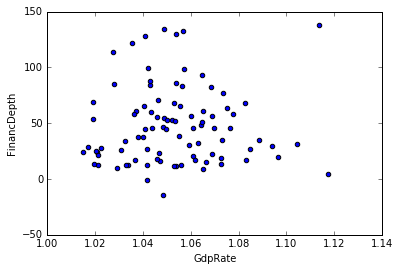

In [33]:
finalSample.plot.scatter("GdpRate","FinancDepth")